# 1. Data pre-processing

In [1]:
#Imports

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [ ]:
# Helper functions


#1 convert -1,0,1 to negative positive and neutral
def sentiment_text(x):
    if x == -1.0:
        return 'Negative'
    elif x == 0.0:
        return "Neutral"
    elif x == 1:
        return "Positive"


#2 Test the model on the unseen dataset
def test_model(text_classifier):
    predictions = text_classifier.predict(processed_test_features)
    print(confusion_matrix(test_labels, predictions))
    print(classification_report(test_labels, predictions))
    print("Accuracy Score on the unlabeled data is: ",
          accuracy_score(test_labels, predictions))


#3 function to save it inside pickle file
def save_model(text_classifier, X_train, y_train, file_name):
    tuple_objects = (text_classifier, X_train, y_train)
    # Save tuple
    pickle.dump(tuple_objects, open(file_name, 'wb'))

In [2]:
#Importing Train data
df = pd.read_csv('Twitter_Data.csv')

#slicing the data set because its too big
df_train = df.iloc[:13871] 

#labeling the labels
df_train.category = df_train.category.apply(sentiment_text)

#Train labels and features
labels = df_train.iloc[:, 1].values
features = df_train.iloc[:, 0].values


#Test labels and features
df_test = pd.read_csv('test_data.csv')
test_labels = df_test['Answer']
test_features = df_test['Stemmed Tweets']

#Combined the features together so that can perform vectorisation and data preperation
combined_features = np.hstack((features,test_features))

C:\Users\Razer\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4]:
#Clean the features AKA the texts 

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

porter = PorterStemmer()
lancaster=LancasterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

processed_features = []

for sentence in range(0, len(combined_features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(combined_features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()
    
    #stem it
    processed_feature = stemSentence(processed_feature)

    processed_features.append(processed_feature)
    
# remove stopwards and tokenize. Keep only the top 2321 most occuring words    
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=5000, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Razer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Razer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#Earlier we processed both data sets together, now we split them back up
processed_train_features = processed_features[:13871]
processed_test_features = processed_features[13871:]

#Training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_train_features, labels, test_size=0.01, random_state=0)

# 2. RandomForest

In [6]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train   , y_train)

predictions = text_classifier.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))


[[23  5  8]
 [ 3 35  7]
 [ 3  8 47]]
              precision    recall  f1-score   support

    Negative       0.79      0.64      0.71        36
     Neutral       0.73      0.78      0.75        45
    Positive       0.76      0.81      0.78        58

    accuracy                           0.76       139
   macro avg       0.76      0.74      0.75       139
weighted avg       0.76      0.76      0.75       139

0.7553956834532374


In [7]:
test_model(text_classifier)  

[[ 61 119 120]
 [ 18 193  89]
 [  9  62 229]]
              precision    recall  f1-score   support

    Negative       0.69      0.20      0.31       300
     Neutral       0.52      0.64      0.57       300
    Positive       0.52      0.76      0.62       300

    accuracy                           0.54       900
   macro avg       0.58      0.54      0.50       900
weighted avg       0.58      0.54      0.50       900

0.5366666666666666


In [8]:
#saving the model
save_model(text_classifier, X_train, y_train,"random_forest_GenericTweets_model.pkl")    


# 3. Knn

In [9]:
from sklearn.neighbors import KNeighborsClassifier

text_classifier = KNeighborsClassifier(n_neighbors=1)
text_classifier.fit(X_train, y_train)

predictions = text_classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

test_model(text_classifier)

[[ 6 28  2]
 [ 1 43  1]
 [ 1 52  5]]
              precision    recall  f1-score   support

    Negative       0.75      0.17      0.27        36
     Neutral       0.35      0.96      0.51        45
    Positive       0.62      0.09      0.15        58

    accuracy                           0.39       139
   macro avg       0.57      0.40      0.31       139
weighted avg       0.57      0.39      0.30       139

0.38848920863309355
[[  3 294   3]
 [  0 298   2]
 [  1 294   5]]
              precision    recall  f1-score   support

    Negative       0.75      0.01      0.02       300
     Neutral       0.34      0.99      0.50       300
    Positive       0.50      0.02      0.03       300

    accuracy                           0.34       900
   macro avg       0.53      0.34      0.18       900
weighted avg       0.53      0.34      0.18       900

0.34


1
done with 1
2
done with 2
3
done with 3
4
done with 4
5
done with 5
6
done with 6
7
done with 7
8
done with 8
9
done with 9
10
done with 10
11
done with 11
12
done with 12
13
done with 13
14
done with 14


Text(0, 0.5, 'Mean Error')

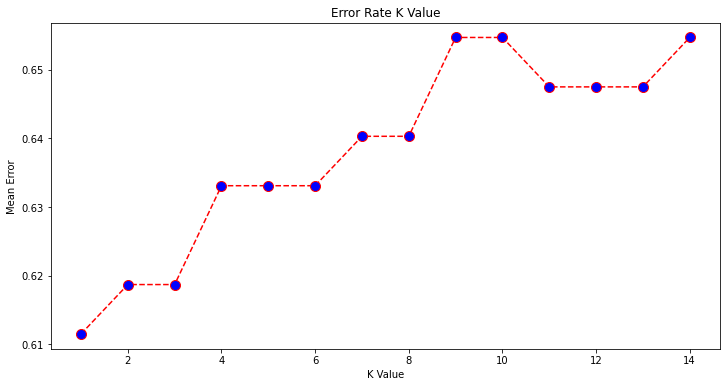

In [10]:
#Finding best value for neighbours

import numpy as np

error = []

# Calculating error for K values between 1 and 5
for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# 4.1 Linear (simple) SVM (support vector machine)


In [11]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

test_model(svclassifier)

[[30  2  4]
 [ 1 39  5]
 [ 6 11 41]]
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82        36
     Neutral       0.75      0.87      0.80        45
    Positive       0.82      0.71      0.76        58

    accuracy                           0.79       139
   macro avg       0.79      0.80      0.80       139
weighted avg       0.79      0.79      0.79       139

0.7913669064748201
[[ 66 129 105]
 [ 17 206  77]
 [  8  74 218]]
              precision    recall  f1-score   support

    Negative       0.73      0.22      0.34       300
     Neutral       0.50      0.69      0.58       300
    Positive       0.55      0.73      0.62       300

    accuracy                           0.54       900
   macro avg       0.59      0.54      0.51       900
weighted avg       0.59      0.54      0.51       900

0.5444444444444444


# 4.2 Kernal SVM (Guassian and sigmoid)

In [12]:
#Polynomial

from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

test_model(svclassifier)


[[ 4  0 32]
 [ 0  8 37]
 [ 0  0 58]]
              precision    recall  f1-score   support

    Negative       1.00      0.11      0.20        36
     Neutral       1.00      0.18      0.30        45
    Positive       0.46      1.00      0.63        58

    accuracy                           0.50       139
   macro avg       0.82      0.43      0.38       139
weighted avg       0.77      0.50      0.41       139

0.5035971223021583
[[  0   0 300]
 [  0   0 300]
 [  0   0 300]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       300
     Neutral       0.00      0.00      0.00       300
    Positive       0.33      1.00      0.50       300

    accuracy                           0.33       900
   macro avg       0.11      0.33      0.17       900
weighted avg       0.11      0.33      0.17       900

0.3333333333333333


C:\Users\Razer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Razer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Razer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [13]:
#Guassian and sigmoid (binary)
from sklearn.svm import SVC

for i in ['rbf', 'sigmoid']:
    print("====", i, '====')
    svclassifier = SVC(kernel=i)
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    from sklearn.metrics import classification_report, confusion_matrix
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    test_model(svclassifier)

==== rbf ====
[[28  4  4]
 [ 2 39  4]
 [ 4 12 42]]
              precision    recall  f1-score   support

    Negative       0.82      0.78      0.80        36
     Neutral       0.71      0.87      0.78        45
    Positive       0.84      0.72      0.78        58

    accuracy                           0.78       139
   macro avg       0.79      0.79      0.79       139
weighted avg       0.79      0.78      0.78       139

0.7841726618705036
[[ 48 150 102]
 [  8 216  76]
 [  5  76 219]]
              precision    recall  f1-score   support

    Negative       0.79      0.16      0.27       300
     Neutral       0.49      0.72      0.58       300
    Positive       0.55      0.73      0.63       300

    accuracy                           0.54       900
   macro avg       0.61      0.54      0.49       900
weighted avg       0.61      0.54      0.49       900

0.5366666666666666
==== sigmoid ====
[[31  2  3]
 [ 4 36  5]
 [ 6 12 40]]
              precision    recall  f1-score   su